# Dark Matter Halo Mass Prediction

Evaluation Metrics: MSE (Mean Squared Error)

Approach Used: Experiment with different architectures of neural networks. Evaluate and determine the best performing neural network.

# 1. Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import platform
from tqdm import tqdm
import random
import glob
import copy
from dataclasses import dataclass
import time
from collections import Counter
from collections import defaultdict
import gc
import tarfile

import sklearn
from sklearn.model_selection import train_test_split

import albumentations as A

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models

import timm
import cv2

import warnings
warnings.filterwarnings("ignore")

Check for GPU availability

In [ ]:
!nvidia-smi

Thu Mar 23 05:31:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define a `CONFIG` class containing different hyperparameters for our models, set a common random seed and use the `DEVICE` (GPU) to train the models.

In [ ]:
@dataclass
class CONFIG:
    RANDOM_SEED = 42
    NUM_WORKERS = 8
    BATCH_SIZE = 16
    MODEL_NAMES = ["efficientnet_b4", "convnext_base", "inception_resnet_v2"]
    DROPOUT = 0.3
    LEARNING_RATE = 5e-5
    EPOCHS = 20

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device("cuda:0")
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device("cpu")
    
set_seed(CONFIG.RANDOM_SEED)
get_device()

[INFO] Using GPU: Tesla P100-PCIE-16GB



Extract the data from the `.tgz` file

In [ ]:
tar = tarfile.open("/kaggle/input/deep-lense-specific-task-3/lens_data_alt.tgz", "r:gz")

tar_directory_structure = tar.getnames()

paths_to_discard = ["lens_data"]

for paths in paths_to_discard:
    if(paths in tar_directory_structure):
        tar_directory_structure.remove(paths)

tar.extractall(path=".", members=None, numeric_owner=False)

Display a random image from the dataset using the `display_random_image` function

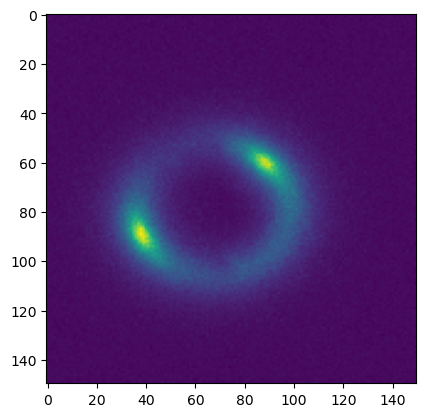

In [ ]:
def display_random_image(tar_directory_structure):
    
    random_number = random.randint(0, len(tar_directory_structure))

    img, _ = np.load(tar_directory_structure[random_number], allow_pickle=True)
    plt.imshow(img)
    plt.show()
    
display_random_image(tar_directory_structure)

Store the masses of each sample in `mass_list`

In [ ]:
mass_list = []

for image_path in tar_directory_structure:
    _, mass = np.load(image_path, allow_pickle=True)
    mass_list.append(mass)

assert len(tar_directory_structure) == len(mass_list)

# 2. Train Test Split

The train:test split is in the ratio 90:10, as mentioned in the submission guidelines 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tar_directory_structure, mass_list, test_size=0.1, random_state=CONFIG.RANDOM_SEED)

print(f"Length of training data: {len(X_train)}")
print(f"Length of testing data: {len(X_test)}")
print(f"Length of training labels: {len(y_train)}")
print(f"Length of testing labels: {len(y_test)}")

Length of training data: 18000
Length of testing data: 2000
Length of training labels: 18000
Length of testing labels: 2000


# 3. Creating a Custom Dataset Class

In [ ]:
class GSoCDeepLensePrivateDatasetSpecificTask3(Dataset):
    
    def __init__(self, image_paths, masses, transform=False):
        self.image_paths = image_paths
        self.masses = masses
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image, _ = np.load(image_filepath, allow_pickle=True)
        image = np.expand_dims(image, axis=2)
        
        mass = self.masses[idx]
        
        if(self.transform is not False):
            image = self.transform(image=image)["image"]
            
        return image, mass

train_dataset = GSoCDeepLensePrivateDatasetSpecificTask3(X_train, y_train, False)
val_dataset = GSoCDeepLensePrivateDatasetSpecificTask3(X_test, y_test, False)

# 4. Visualizing Images

Taking a look at the images present in the train and valid sets respectively

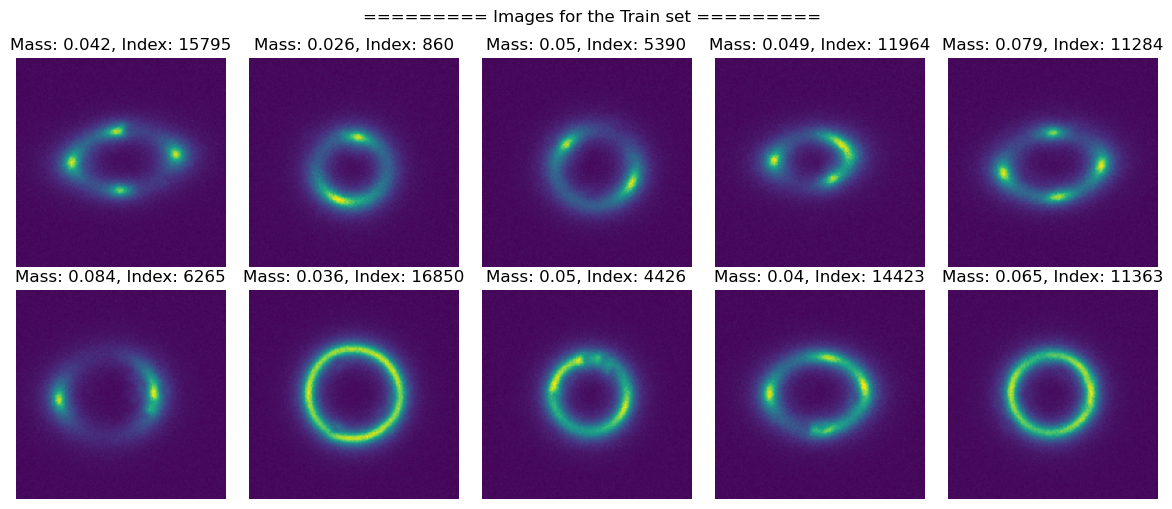

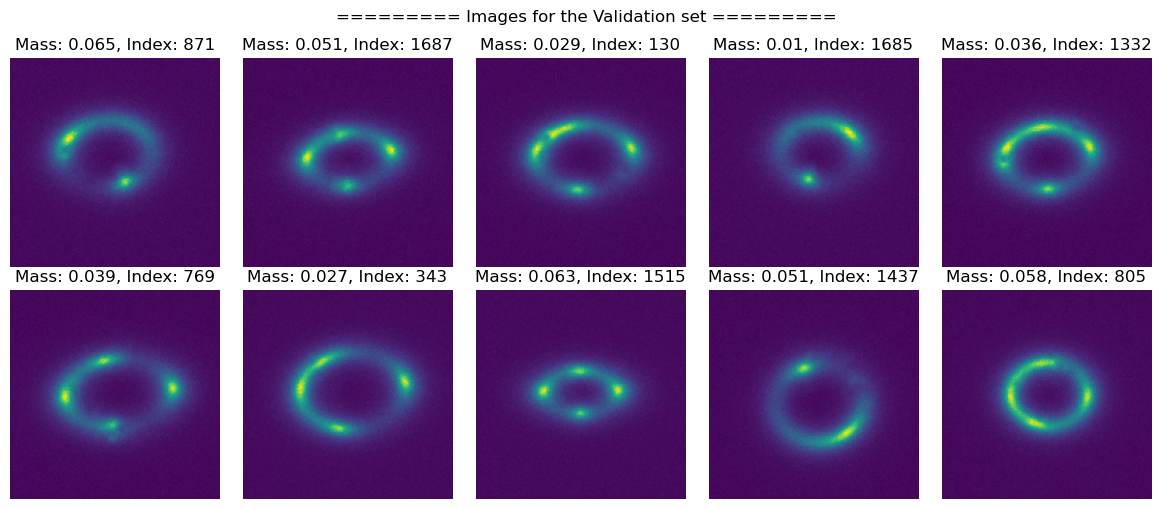

In [ ]:
def visualize_images(dataset_input, dataset_type, samples, cols):
    
    dataset_len = len(dataset_input)
    dataset = dataset_input
    
    rows = samples // cols
    
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
    fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, mass = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Mass: {round(mass, 3)}, Index: {idx}")
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()
    
visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

# 5. Create Dataloaders

In [ ]:
def make_data_loader(dataset, shuffle):
    
    loader = DataLoader(dataset, batch_size=CONFIG.BATCH_SIZE, num_workers=CONFIG.NUM_WORKERS, shuffle=shuffle)
    
    return loader

train_loader = make_data_loader(dataset=train_dataset, shuffle=True)
val_loader = make_data_loader(dataset=val_dataset, shuffle=False)

# a, b = next(iter(train_loader))
# a = a.permute(0, 3, 1, 2)
# a.shape

# timm.list_models("inception*")

Creating custom model classes that inherit from `nn.Module`

In [ ]:
class EfficientNetB4(nn.Module):
    
    def __init__(self, number_of_output_neurons):
        
        super(EfficientNetB4, self).__init__()
        
        self.effnetmodel = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.effnetmodel.parameters():
            param.requires_grad = True
            
        self.regressor = nn.Sequential(
            nn.Linear(1792 * 5 * 5, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, number_of_output_neurons)
        )
                
    def forward(self, x):
        x = self.effnetmodel.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 1792 * 5 * 5)
        x = self.regressor(x)
        
        return x
    
class Convnext_Base(nn.Module):
    
    def __init__(self, number_of_output_neurons):
        
        super(Convnext_Base, self).__init__()
        
        self.model = timm.create_model(CONFIG.MODEL_NAMES[1], pretrained=True, in_chans=1)
        
        for param in self.model.parameters():
            param.requires_grad = True
            
        self.regressor = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, number_of_output_neurons)
        )
                
    def forward(self, x):
        x = self.model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 1024 * 4 * 4)
        x = self.regressor(x)
        
        return x
    
class Inception_Resnet_V2(nn.Module):
    
    def __init__(self, number_of_output_neurons):
        
        super(Inception_Resnet_V2, self).__init__()
        
        self.model = timm.create_model(CONFIG.MODEL_NAMES[2], pretrained=True, in_chans=1)
        
        for param in self.model.parameters():
            param.requires_grad = True
            
        self.regressor = nn.Sequential(
            nn.Linear(1536 * 3 * 3, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, number_of_output_neurons)
        )
        
    def forward(self, x):
        x = self.model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 1536 * 3 * 3)
        x = self.regressor(x)
        
        return x

Initialize `model` as an instance of one of the classes previously created

In [ ]:
model = Inception_Resnet_V2(1)
model = model.to(DEVICE)
# x = torch.randn(CONFIG.BATCH_SIZE, 1, 150, 150).to(DEVICE)
# model(x).shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth


Trains the model for 1 epoch

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, device):
    
    model.train()
    
    train_loss = []
    
    for i, data in enumerate(tqdm(data_loader, colour="blue")):
        images, masses = data
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        masses = masses.to(device)
        
        y_pred = model(images.float())
        y_pred = y_pred.view(-1)
        y_pred = y_pred.type(torch.float64)
        
        loss = criterion(y_pred, masses)
        
#         print("masses dtype:", masses.dtype)
#         print("y_pred dtype:", y_pred.dtype)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print(f"MSE Train Loss (per 10 batches): {loss}")
            
        train_loss.append(torch.tensor(loss))
        
    return train_loss

Tests the performance of the trained model

In [ ]:
def test_model(model, criterion, data_loader, device):
    
    model.eval()
    
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, colour="blue")):
            images, masses = data
            images = images.permute(0, 3, 1, 2)
            images = images.to(device)
            masses = masses.to(device)
            
            y_pred = model(images.float())
            y_pred = y_pred.view(-1)
            y_pred = y_pred.type(torch.float64)
            
            loss = criterion(y_pred, masses)
            
            if(i % 10 == 0):
                print(f"MSE Val Loss (per 10 batches): {loss}")
            
            val_loss.append(torch.tensor(loss))
            
    return val_loss

Converts tensor-lists to numpy arrays and computes the mean value

In [ ]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    
    return np.mean(tensor_list)

Criterion and optimizer used to train the model

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

# 6. Training the Model

Cell commented out to save GPU time

In [ ]:
# %%time

# history = defaultdict(list)
# best_loss = 1
# model_name = CONFIG.MODEL_NAMES[2]

# for epoch in range(CONFIG.EPOCHS):
#     print(f"Epoch {epoch + 1} / {CONFIG.EPOCHS}")
#     print('=' * 10)
    
#     train_loss = train_one_epoch(model=model, optimizer=optimizer, criterion=criterion, data_loader=train_loader, device=DEVICE)
#     train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
#     print(f'Train loss: {train_loss}\n')
    
#     val_loss = test_model(model=model, criterion=criterion, data_loader=val_loader, device=DEVICE)
#     val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
#     print(f'Val loss: {val_loss}\n')
    
#     history['train_loss'].append(train_loss)
#     history['val_loss'].append(val_loss) 
    
#     if(val_loss < best_loss):
#         torch.save(model.state_dict(), 
#                    f'{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.pth')
#         best_loss = val_loss
#         print(f"Best Loss is: {best_loss}")
#         print("Model saved succesfully")
#         print("\n")

# 7. Visualizing Model Performance

In [ ]:
# def generate_loss_plots(history):

#     ax = plt.figure().gca()
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#     plt.plot(history['train_loss'], label='Training Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.ylim([0, 1])
#     plt.show()
    
# generate_loss_plots(history)

Loading all the previously trained models

In [ ]:
model1 = EfficientNetB4(1).to(DEVICE)
model1.load_state_dict(torch.load("/kaggle/input/deep-lense-task3-models/efficientnet_b4_epochs_10_batchsize_128_lr_0.0005.pth"))

model2 = Convnext_Base(1).to(DEVICE)
model2.load_state_dict(torch.load("/kaggle/input/deep-lense-task3-models/convnext_base_epochs_25_batchsize_128_lr_5e-05.pth"))

model3 = Inception_Resnet_V2(1).to(DEVICE)
model3.load_state_dict(torch.load("/kaggle/input/deep-lense-task3-models/inception_resnet_v2_epochs_20_batchsize_128_lr_5e-05.pth"))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth
Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


<All keys matched successfully>

# 8. Model Predictions

In [ ]:
def test_final_model_mse(model, criterion, data_loader, device):
    
    model.eval()
    
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, colour="blue")):
            images, masses = data
            images = images.permute(0, 3, 1, 2)
            images = images.to(device)
            masses = masses.to(device)
            
            y_pred = model(images.float())
            y_pred = y_pred.view(-1)
            y_pred = y_pred.type(torch.float64)
            
            loss = criterion(y_pred, masses)
            
            val_loss.append(torch.tensor(loss))
            
    return convert_tensor_list_to_single_mean_value(val_loss)

model1_mse = test_final_model_mse(model1, criterion, val_loader, DEVICE)
model2_mse = test_final_model_mse(model2, criterion, val_loader, DEVICE)
model3_mse = test_final_model_mse(model3, criterion, val_loader, DEVICE)

100%|██████████| 125/125 [00:07<00:00, 16.51it/s]


# 9. Final Model Results

In [ ]:
def display_results(model_name, mse):
    
    print(f"For {model_name} the MSE is {mse}")
    
display_results("EfficientNetB4", model1_mse)
display_results("ConvNeXt", model2_mse)
display_results("InceptionResnetV2", model3_mse)

For EfficientNetB4 the MSE is 0.00020073669395494556
For ConvNeXt the MSE is 0.0002763208888364335
For InceptionResnetV2 the MSE is 0.00026177410163290824
